# Сравнение моделей на данных MNIST

In [2]:
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier

import optuna
from tqdm import tqdm

In [3]:
# скачиваем данные
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
# что за данные
print(x_train.shape)
print(x_test.shape)
print (y_train[:10])
print (y_test[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


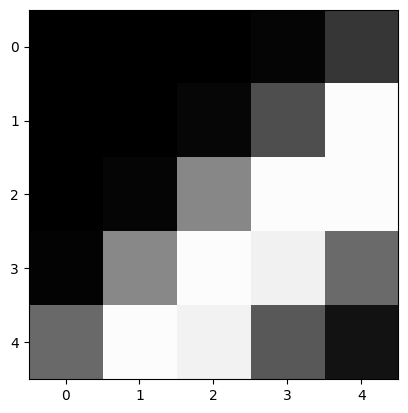

Пример картинки:


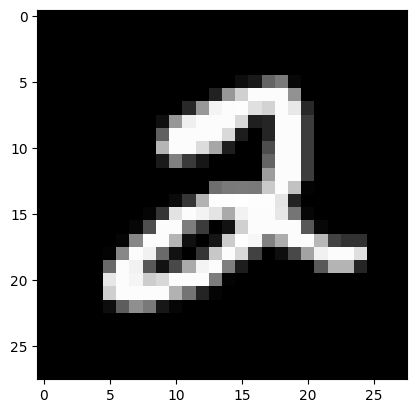

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [5]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

# Линейная модель

Линейная модель не умеет работать с двумерным входом, поэтому мы *вытянем* картинку 28x28 в вектор длины 28*28=784

In [6]:
x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train_flat.shape)

x_test_flat = x_test.reshape(-1, 28*28).astype(float)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


Данные необходимо стандартизировать

In [7]:
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_test_flat = scaler.transform(x_test_flat)

In [8]:
# кусочек фичей
x_train_flat[0, ::20]

array([ 0.        ,  0.        , -0.03059266, -0.00852241, -0.01408835,
       -0.2625969 , -0.16124756,  0.        ,  1.71565971,  0.74933951,
       -0.11300485, -0.19700703,  1.12192712,  0.27021375, -0.00577281,
       -0.70132425,  1.64634567, -0.1273685 , -0.15382451, -0.19833719,
       -0.70732309, -0.00477028, -0.60978718, -0.9194134 , -0.17786005,
       -0.16833376,  0.65022085, -0.63188648,  0.        , -0.48806277,
        1.17394853, -0.14774138, -0.07003976, -0.61257571,  3.52099754,
        0.        , -0.09396514, -0.1826269 , -0.00579016,  0.        ])

In [9]:
%%time
# обучаем линейную модель
clf = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs", # градиентный метод оптимизации
    max_iter=3000
)
clf.fit(x_train_flat, y_train)

# Выведем отчет по метрикам
print(metrics.classification_report(
    y_test, clf.predict(x_test_flat), digits=5
    )
)

              precision    recall  f1-score   support

           0    0.94800   0.96735   0.95758       980
           1    0.95686   0.97709   0.96687      1135
           2    0.91708   0.88953   0.90310      1032
           3    0.90098   0.90990   0.90542      1010
           4    0.93648   0.93075   0.93361       982
           5    0.89171   0.86771   0.87955       892
           6    0.94301   0.94990   0.94644       958
           7    0.93097   0.91829   0.92458      1028
           8    0.87005   0.87988   0.87494       974
           9    0.91206   0.91477   0.91341      1009

    accuracy                        0.92160     10000
   macro avg    0.92072   0.92052   0.92055     10000
weighted avg    0.92146   0.92160   0.92146     10000

CPU times: total: 1min 27s
Wall time: 9.95 s


Вышло не так уж и плохо!

# Градиентный бустинг

<img src="https://www.researchgate.net/profile/Maria_Peraita-Adrados/publication/326379229/figure/fig5/AS:647978477948928@1531501516288/A-simple-example-of-visualizing-gradient-boosting_W640.jpg" width="300">

Над деревьями делают бустинг и это богатое семейство алгоритмов частенько занимает лучшие места на Kaggle. Проверим ее в нашей задаче.

In [19]:
%%time
clf = ensemble.GradientBoostingClassifier()
clf.fit(x_train_flat, y_train)

# Выведем отчет по метрикам
print(metrics.classification_report(
    y_test, clf.predict(x_test_flat), digits=5
    )
)

              precision    recall  f1-score   support

           0    0.96600   0.98571   0.97576       980
           1    0.97474   0.98590   0.98029      1135
           2    0.94862   0.93023   0.93933      1032
           3    0.93097   0.93465   0.93281      1010
           4    0.94501   0.94501   0.94501       982
           5    0.94064   0.92377   0.93213       892
           6    0.96008   0.95407   0.95707       958
           7    0.96076   0.92899   0.94461      1028
           8    0.91491   0.93840   0.92651       974
           9    0.91398   0.92666   0.92028      1009

    accuracy                        0.94590     10000
   macro avg    0.94557   0.94534   0.94538     10000
weighted avg    0.94601   0.94590   0.94588     10000

CPU times: total: 38min
Wall time: 38min 1s


Как видим, алгоритм работает очень долго: потому что он переборный. Дешевле будет использовать какие-нибудь модификации логистической регрессии.

Также градиентный бустинг очень чувствителен к размеру данных: как к числу объектов, так и к числу признаков. Но в том же sklearn имеется модификация классического GB:

In [22]:
%%time
clf = ensemble.HistGradientBoostingClassifier()
clf.fit(x_train_flat, y_train)

# Выведем отчет по метрикам
print(metrics.classification_report(
    y_test, clf.predict(x_test_flat), digits=5
    )
)

              precision    recall  f1-score   support

           0    0.98081   0.99082   0.98579       980
           1    0.98941   0.98767   0.98854      1135
           2    0.97195   0.97384   0.97289      1032
           3    0.97162   0.98317   0.97736      1010
           4    0.98253   0.97352   0.97801       982
           5    0.97851   0.96973   0.97410       892
           6    0.97914   0.98017   0.97966       958
           7    0.98037   0.97179   0.97606      1028
           8    0.97032   0.97331   0.97181       974
           9    0.96630   0.96630   0.96630      1009

    accuracy                        0.97720     10000
   macro avg    0.97710   0.97703   0.97705     10000
weighted avg    0.97722   0.97720   0.97720     10000

CPU times: total: 9min 15s
Wall time: 1min 34s


И он намного быстрее! И лучше! Но у него есть достойный соперник в том же парке моделей sklearn.

# Нейросети

Соберем сложную функцию как комбинацию простых линейных моделей (например, логистических регрессий).

Для оптимизации всех параметров нам не нужен перебор, мы можем честно посчитать производную потерь по каждому параметру и чуточку их подвинуть! Это работает очень быстро!


In [10]:
%%time
# многослойный перцептрон (просто много полносвязных слоев)
clf = MLPClassifier()
clf.fit(x_train_flat, y_train)

# Выведем отчет по метрикам
print(metrics.classification_report(
    y_test, clf.predict(x_test_flat), digits=5
    )
)

              precision    recall  f1-score   support

           0    0.97883   0.99082   0.98479       980
           1    0.98771   0.99119   0.98945      1135
           2    0.96787   0.96318   0.96552      1032
           3    0.96408   0.98317   0.97353      1010
           4    0.97739   0.96843   0.97289       982
           5    0.96745   0.96637   0.96691       892
           6    0.97908   0.97704   0.97806       958
           7    0.97466   0.97276   0.97371      1028
           8    0.96898   0.96201   0.96548       974
           9    0.97297   0.96333   0.96813      1009

    accuracy                        0.97410     10000
   macro avg    0.97390   0.97383   0.97385     10000
weighted avg    0.97410   0.97410   0.97408     10000

CPU times: total: 52.1 s
Wall time: 21.8 s


Качество сопоставимое, а скорость еще выше!

Попробуем оптимизировать нашу нейросетку, добавив также возможность углубления.

In [14]:
# Сперва выделим валидационную выборку
x_valid_flat = x_train_flat[50000:, :]
x_train_flat = x_train_flat[:50000, :]

y_valid = y_train[50000:]
y_train = y_train[:50000]

Label: 3


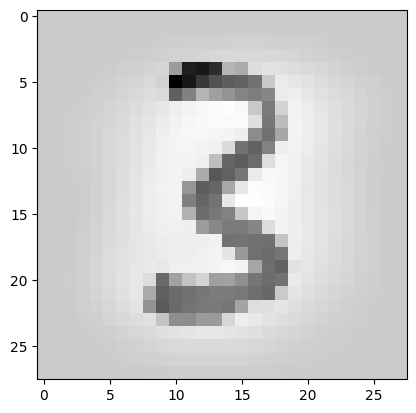

In [45]:
x_valid_image = x_valid_flat[0].reshape(1, 28, 28)

print('Label:', y_valid[0])
plt.imshow(x_valid_image[0], cmap="Greys")
plt.show()

In [48]:
# Напишем функцию для оптимизации
def optuna_mlp(trial):
    """Функция, обучающая модель MLPClassifier по переданным гиперпараметрам
    Args:
        trial : класс, от которого вызываются гиперпараметры
    Returns:
        score(float): метрика F1-weighted
    """
    # Задаем пространство поиска гиперпараметров
    params = {
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
    }
    
    if trial.suggest_categorical('use_second_hidden_layer', [True, False]):
        params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 256),
                                         trial.suggest_int('n_units2', 1, 256))
    else:
        params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 256),)
    
    # Инициализация MLPClassifier с оптимизируемыми гиперпараметрами
    clf = MLPClassifier(
        **params,
        max_iter=1000,
        random_state=42
    )
    
    # Вычисление метрики 
    clf.fit(x_train_flat, y_train)
    valid_preds = clf.predict(x_valid_flat)
    score = metrics.f1_score(y_valid, valid_preds, average='weighted')

    return score


# Создаем объект исследования для первого набора гиперпараметров
# Укажем, что нам необходимо максимизировать метрику direction="maximize"
study_mlp = optuna.create_study(study_name="mlp_opt", direction='maximize')
# Подавляем логирование
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Мониторим прогресс оптимизации
with tqdm(total=10, desc="Optimizing") as pbar:
    def update(study, trial):
        pbar.update()
    # Ищем лучшую комбинацию гиперпараметров n_trials раз
    study_mlp.optimize(optuna_mlp, n_trials=10, callbacks=[update])

best_params = study_mlp.best_params
n_units1 = best_params.pop('n_units1')
flag = best_params.pop('use_second_hidden_layer')
if flag:
    n_units2 = best_params.pop('n_units2')
    hidden_layer_sizes = (n_units1, n_units2)
else:
    hidden_layer_sizes = (n_units1,)

In [49]:
%%time
# Оптимальные гиперпараметры
print("Лучшие гиперпараметры:", study_mlp.best_params)

# Передаем модели коллекцию оптимальных гиперпараметров
mlpc_opt = MLPClassifier(
    hidden_layer_sizes=hidden_layer_sizes,
    **best_params,
    max_iter=3000,
    random_state=42
)

# Обучение
mlpc_opt.fit(x_train_flat, y_train)

# Выведем отчет по метрикам
print(metrics.classification_report(
    y_test, mlpc_opt.predict(x_test_flat), digits=5
    )
)

Лучшие гиперпараметры: {'activation': 'relu', 'alpha': 0.0026662147964328486, 'learning_rate': 'adaptive', 'use_second_hidden_layer': True, 'n_units1': 99, 'n_units2': 89}
              precision    recall  f1-score   support

           0    0.97980   0.98980   0.98477       980
           1    0.99208   0.99383   0.99296      1135
           2    0.96996   0.96996   0.96996      1032
           3    0.96282   0.97426   0.96850      1010
           4    0.97955   0.97556   0.97755       982
           5    0.97941   0.95964   0.96942       892
           6    0.97604   0.97808   0.97706       958
           7    0.97363   0.96984   0.97173      1028
           8    0.97013   0.96715   0.96864       974
           9    0.97134   0.97423   0.97279      1009

    accuracy                        0.97560     10000
   macro avg    0.97548   0.97523   0.97534     10000
weighted avg    0.97562   0.97560   0.97559     10000

CPU times: total: 1min 17s
Wall time: 31.3 s


Удалось немного приподнять метрики.

На сегодня в работе с нетабличными данными нейросети превосходят классические алгоритмы машинного обучения.